<a href="https://colab.research.google.com/github/zeerafle/sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Airline Sentiment Analysis

## Setup

In [1]:
import sys  
!{sys.executable} -m pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 40.0 MB/s 
     |████████████████████████████████| 287 kB 58.9 MB/s 


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re
import contractions

from wordcloud import WordCloud

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [7]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data Preprocessing and Exploration

Ambil dataset [Kaggle US Airline Sentiment Analysis](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%%bash
pip install kaggle
mkdir ~/.kaggle
cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d crowdflower/twitter-airline-sentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



100%|██████████| 2.55M/2.55M [00:01<00:00, 2.37MB/s]


In [10]:
%%bash
mkdir dataset
unzip twitter-airline-sentiment.zip -d dataset

Archive:  twitter-airline-sentiment.zip
  inflating: dataset/Tweets.csv      
  inflating: dataset/database.sqlite  


In [11]:
raw_df = pd.read_csv('dataset/Tweets.csv')
raw_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
raw_df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### Bersihkan Text

Proses pembersihan teks meliputi:
- Jadikan huruf kecil semua
- Hilangkan mention
- Hilangkan link url
- Hilangkan hashtag
- Hilangkan tag html
- Ganti kata yang disingkat (misal: i've --> i have)
- Hilangkan angka
- Ganti `?` jadi "questionmark"
- Ganti `!` jadi "exclamationmark"
- Hilangkan semua kecuali kata dan spasi
- Hilangkan spasi berlebih

In [13]:
df = raw_df[['text', 'airline_sentiment']]

In [14]:
# jadikan huruf kecil dan hilangkan mention
X_clean = df['text'].apply(lambda x: re.sub("\\@.*? |\\@.*?[!'#S%&'()*+,-./:;<=>?@[/]^_{|}~]|\\@.*", " ", x.lower()))
# hilangkan link url
X_clean = X_clean.apply(lambda x: re.sub("http.*? |http.*?[!'#S%&'()*+,-./:;<=>?@[/]^_{|}~]|http.*", " ", x))
# hilangkan hashtag
X_clean = X_clean.apply(lambda x: re.sub("#.*? |#.*?[!'#S%&'()*+,-./:;<=>?@[/]^_{|}~]|#.*", " ", x))
# hilangkan html tag
X_clean = X_clean.apply(lambda x: re.sub("<.*?>", " ", x))
# ganti kata yang disingkat
X_clean = X_clean.apply(lambda x: contractions.fix(x))
# hilangkan angka
X_clean = X_clean.apply(lambda x: re.sub("[0-9]", " ", x))
# Ganti ? jadi "questionmark"
X_clean = X_clean.apply(lambda x: re.sub("[?]", " questionmark", x))
# Ganti ! jadi "exclamationmark"
X_clean = X_clean.apply(lambda x:  re.sub("[!]", " exclamationmark", x))
# Hilangkan semua kecuali kata dan spasi
X_clean = X_clean.apply(lambda x: re.sub("'s", " ", x))
X_clean = X_clean.apply(lambda x: re.sub("[^\w\s]", " ", x))
# Hilangkan spasi berlebih
X_clean = X_clean.apply(lambda x: re.sub(" +", " ", x.strip()))

X_clean

0                                                what said
1        plus you have added commercials to the experie...
2        i did not today must mean i need to take anoth...
3        it is really aggressive to blast obnoxious ent...
4                and it is a really big bad thing about it
                               ...                        
14635    thank you we got on a different flight to chicago
14636    leaving over minutes late flight no warnings o...
14637                    please bring american airlines to
14638    you have my money you change my flight and do ...
14639    we have people so we need know how many seats ...
Name: text, Length: 14640, dtype: object

In [15]:
df['text'] = X_clean

<ipython-input-15-724fcf817da4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = X_clean


### Jumlah kata

Kita perlu cek jumlah tiap kata dalam satu kalimat. Ada text yang cuma berisi 1 atau 2 kata setelah dibersihkan jadi tidak bisa memberikan banyak informasi

In [16]:
word_count = df['text'].apply(lambda x: len(x.split(" ")))
word_count.describe()

count    14640.000000
mean        16.881831
std          7.162187
min          1.000000
25%         11.000000
50%         18.000000
75%         23.000000
max         37.000000
Name: text, dtype: float64

Kita filter dataset supaya cuma menggunakan data yang paling tidak ada 3 kata dalam satu kalimat.

In [17]:
df = df[word_count > 3]
df.shape

(14094, 2)

## Visualisasi WordCloud

<function matplotlib.pyplot.show(*args, **kw)>

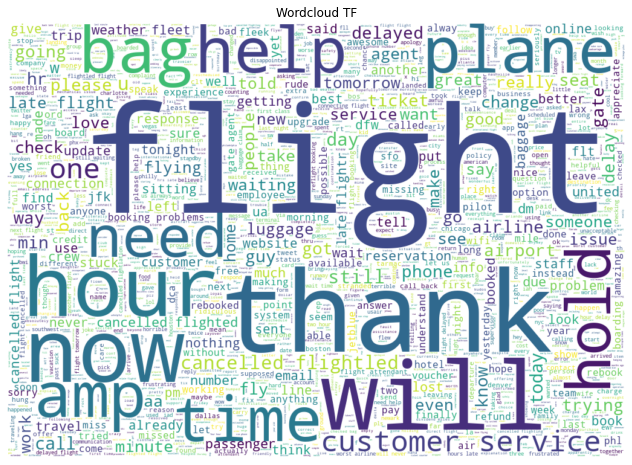

In [23]:
# visualisasi wordcloud
text = " ".join(tweet for tweet in df.text).replace('questionmark', '').replace('exclamationmark', '')
wordcloud = WordCloud(background_color='white', max_words=2000,
                     width=1024, height=720).generate(text)
plt.figure(figsize=(20,8))
plt.title('Wordcloud TF')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show

### Split Train dan Validation data

In [ ]:
X = df['text']
y = pd.get_dummies(df['airline_sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Text preprocessing lanjutan

Dapatkan jumlah vocabulary (jumlah kata-kata yang berbdea) di data train. Ini nanti digunakan di input data

In [ ]:
text_review = ''
for i in range(len(X_train)):
    text_review = text_review + X_train.iloc[i]

len(set(text_review.split()))

15987

### Tokenization

In [ ]:
NUM_WORDS = 15000

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(X_train)

In [ ]:
x_train_token = tokenizer.texts_to_sequences(X_train)
x_test_token = tokenizer.texts_to_sequences(X_test)

In [ ]:
MAXLEN = 250

x_train_padding = pad_sequences(x_train_token, maxlen=MAXLEN, padding='pre', truncating='post')
x_test_padding = pad_sequences(x_test_token, maxlen=MAXLEN, padding='pre', truncating='post')

## Membangun Arsitektur Model

In [ ]:
model = Sequential([
    Embedding(input_dim=NUM_WORDS, input_length=MAXLEN, output_dim=16),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32)),
    Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 16)           240000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 250, 128)         41472     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi validasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = MyCallback()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### Melatih Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(x_train_padding,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test_padding, y_test),
                    verbose=2,
                    callbacks=[callbacks, early_stopping])

Epoch 1/100
353/353 - 21s - loss: 0.7208 - accuracy: 0.7035 - val_loss: 0.5587 - val_accuracy: 0.7868 - 21s/epoch - 58ms/step
Epoch 2/100
353/353 - 13s - loss: 0.4681 - accuracy: 0.8245 - val_loss: 0.5216 - val_accuracy: 0.7992 - 13s/epoch - 38ms/step
Epoch 3/100
353/353 - 12s - loss: 0.3614 - accuracy: 0.8710 - val_loss: 0.5423 - val_accuracy: 0.7843 - 12s/epoch - 35ms/step
Epoch 4/100
353/353 - 12s - loss: 0.2899 - accuracy: 0.9028 - val_loss: 0.5733 - val_accuracy: 0.7857 - 12s/epoch - 35ms/step
Epoch 5/100
353/353 - 12s - loss: 0.2434 - accuracy: 0.9175 - val_loss: 0.6403 - val_accuracy: 0.7868 - 12s/epoch - 35ms/step
Epoch 6/100
353/353 - 13s - loss: 0.2026 - accuracy: 0.9323 - val_loss: 0.6798 - val_accuracy: 0.7896 - 13s/epoch - 36ms/step
Epoch 7/100
353/353 - 13s - loss: 0.1779 - accuracy: 0.9412 - val_loss: 0.7436 - val_accuracy: 0.7708 - 13s/epoch - 37ms/step
Epoch 8/100
353/353 - 12s - loss: 0.1508 - accuracy: 0.9511 - val_loss: 0.8622 - val_accuracy: 0.7744 - 12s/epoch - 35

## Evaluasi Model

### Accuracy and loss graphs

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

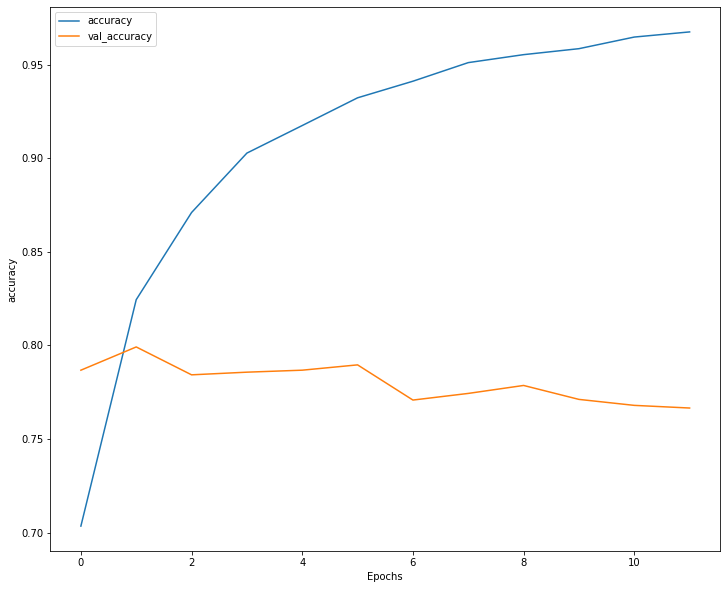

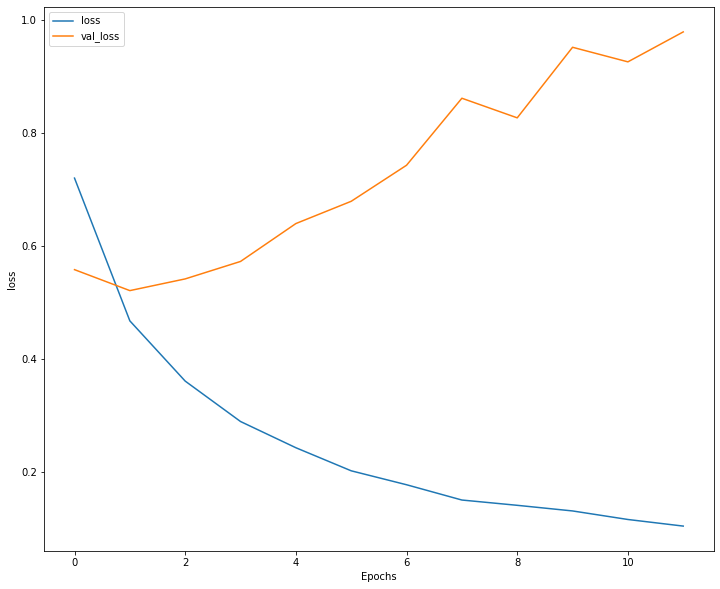

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')